In [10]:
from pathlib import Path

import janitor
import pandas as pd
import plotnine as gg
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
benchmark_dir = Path("../benchmarks/")
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [4]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(rule_d: Path, pipeline_name: str) -> pd.DataFrame:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    for rule_dir in pipeline_dir.iterdir():
        benchmark_df_list.append(
            get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        )

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,2117.6448,0:35:17,1469.34,2337.84,1466.22,1466.44,173.84,13.11,85.60,1812.74,sp4-noncentered-copynum_chain3,sample_mcmc,010_010_run-crc-sampling-snakemake
1,2283.6947,0:38:03,1552.29,2446.18,1505.21,1527.56,59.74,70.80,81.67,1865.28,sp6-default_chain0,sample_mcmc,010_010_run-crc-sampling-snakemake
2,987.0751,0:16:27,1390.21,2253.71,1387.80,1387.87,131.01,62.54,64.37,635.52,sp5-noncentered_chain2,sample_mcmc,010_010_run-crc-sampling-snakemake
3,1971.2692,0:32:51,1491.80,2674.84,1489.37,1489.48,248.46,31.87,95.97,1892.01,sp7-default_chain1,sample_mcmc,010_010_run-crc-sampling-snakemake
4,1169.3888,0:19:29,1410.36,2285.42,1407.70,1407.80,811.38,65.82,77.08,874.76,sp4-centered-copynum_chain3,sample_mcmc,010_010_run-crc-sampling-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [5]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  max_rss  max_vms  \
pipeline                           rule                                     
010_010_run-crc-sampling-snakemake sample_advi  2374.30  1518.44  2298.60   
                                   sample_mcmc  1547.22  1541.49  2447.51   

                                                max_uss  max_pss   io_in  \
pipeline                           rule                                    
010_010_run-crc-sampling-snakemake sample_advi  1512.03  1513.91  359.40   
                                   sample_mcmc  1532.23  1535.69  402.43   

                                                io_out  mean_load  cpu_time  
pipeline                           rule                                      
010_010_run-crc-sampling-snakemake sample_advi   31.48      31.47   2230.69  
                                   sample_mcmc   49.07      78.35   1257.26

In [7]:
benchmark_df_long = benchmark_df[
    ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
].pivot_longer(["pipeline", "rule", "step"])

benchmark_df_long
# (
#     alt.Chart(benchmark_df_long)
#     .mark_boxplot(size=50)
#     .encode(
#         x="rule",
#         y=alt.Y("value", title=""),
#         row=alt.Row("variable", title=""),
#         column=alt.Column("pipeline"),
#     )
#     .properties(width=200, height=100)
#     .resolve_scale(y="independent")
# )

,pipeline,rule,step,variable,value
0,010_010_run-crc-sampling-snakemake,sample_mcmc,sp4-noncentered-copynum_chain3,cpu_time,1812.74
1,010_010_run-crc-sampling-snakemake,sample_mcmc,sp6-default_chain0,cpu_time,1865.28
2,010_010_run-crc-sampling-snakemake,sample_mcmc,sp5-noncentered_chain2,cpu_time,635.52
3,010_010_run-crc-sampling-snakemake,sample_mcmc,sp7-default_chain1,cpu_time,1892.01
4,010_010_run-crc-sampling-snakemake,sample_mcmc,sp4-centered-copynum_chain3,cpu_time,874.76
...,...,...,...,...,...
203,010_010_run-crc-sampling-snakemake,sample_advi,sp4-centered-copynum,cpu_time,28.41
204,010_010_run-crc-sampling-snakemake,sample_advi,sp4-default-fullrank,cpu_time,1647.72
205,010_010_run-crc-sampling-snakemake,sample_advi,sp7-default,cpu_time,20.99
206,010_010_run-crc-sampling-snakemake,sample_advi,sp5-default,cpu_time,22.32


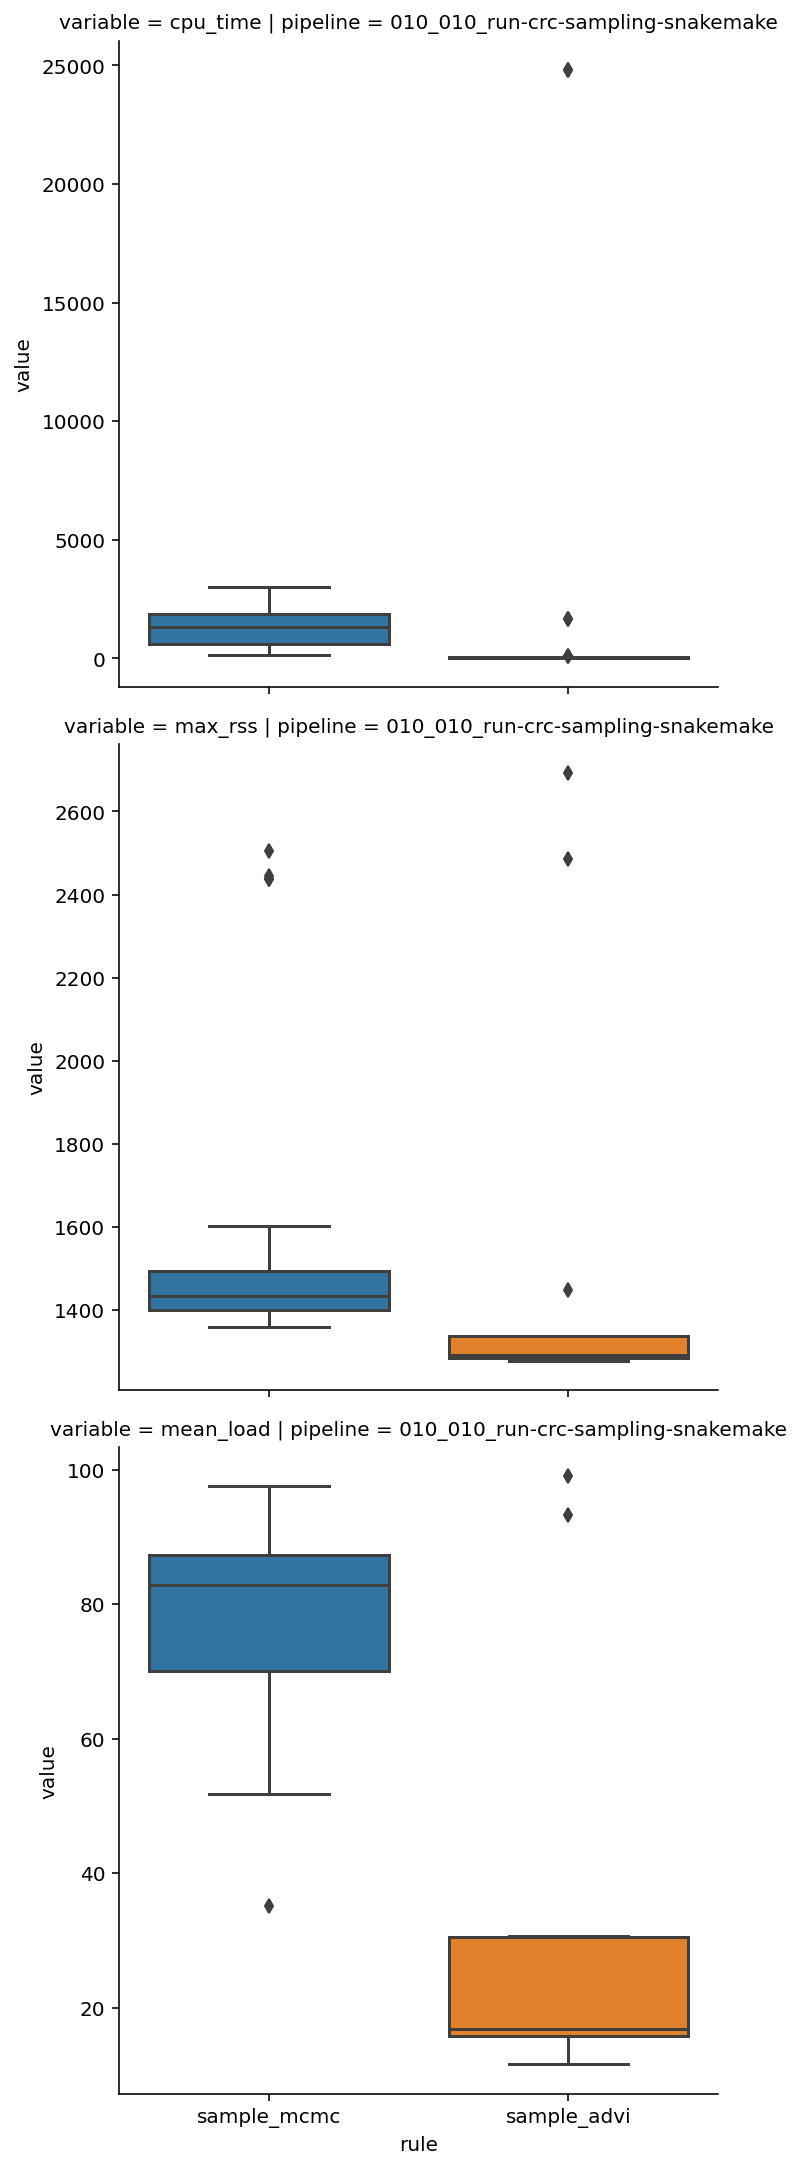

In [13]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
);

---

In [6]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-20

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.24.1

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-171.o2.rc.hms.harvard.edu

Git branch: sp7-parameterizations

janitor: 0.20.14
pandas : 1.2.3
altair : 4.1.0

